In [1]:
import pickle
with open('cache/df.90.pickle', mode='rb') as h:
    df_train, df_test = pickle.load(h)
with open('cache/hex.pickle', mode='rb') as h:
    D = len(pickle.load(h)['id_name'])  # number of labels

In [2]:
df_train.head()

,img,label,size_ratio,pseudo_label
0,2009_001061.jpg,10,0.995339,"(22, 23)"
1,2008_006600.jpg,8,0.007645,"(22, 23)"
2,2010_002200.jpg,11,0.198912,"(22,)"
3,2011_002107.jpg,10,0.947467,"(22, 23)"
4,2009_002712.jpg,6,0.468864,"(22, 23)"


In [3]:
df_train['is_leaf'] = map(lambda x: x[0] in x[1], zip(df_train['label'], df_train['pseudo_label']))

In [6]:
df_small = df_train[df_train['is_leaf']]

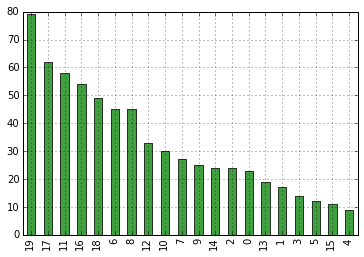

In [8]:
%matplotlib inline
df_small['label'].value_counts().plot(kind='bar', color='green', alpha=0.75, grid=True)

In [2]:
import cv2
import numpy as np
from os.path import join
img_dir = '../pascal12/JPEGImages'
img_mean = np.load('caffe/ilsvrc12_mean.npy').astype(np.float32)  # 3*256*256
img_mean = np.swapaxes(np.swapaxes(img_mean, 0, 1), 1, 2)  # convert to XY[BGR]
def load_image(filename):
    """
    Loads image, subtract mean, resize to 227*227. No axis rotation or normalization.
    Returns:
        Result image as an np.float32 array with size 227*227*3. Values within [0, 255].
    """
    img = cv2.resize(cv2.imread(join(img_dir, filename)), (256, 256))
    return cv2.resize(img.astype(np.float32) - img_mean, (227, 227))

In [3]:
import h5py
def save_hdf5(filename, X, Y_leaf, Y_hierarchy=None):
    with h5py.File('../{}.h5'.format(filename), mode='w') as h:
        h.create_dataset('X', data=X)
        h.create_dataset('Y_leaf', data=Y_leaf)
        if Y_hierarchy is not None:
            h.create_dataset('Y_hierarchy', data=Y_hierarchy)

In [12]:
df_train_leaf = df_train.query('"label" in "pseudolabel"')

KeyError: False

In [10]:
df_train_leaf

""
0
1
2
3
4
5
6
7
8
9


In [4]:
# Training data
X = map(load_image, df_train['img'])
X = np.swapaxes(np.swapaxes(X, 2, 3), 1, 2)  # convert to [BGR]XY for Caffe
Y_leaf = df_train['label'].astype('float32')
Y_hierarchy = np.zeros((len(X), D), dtype=float)
pseudo_labels = df_train['pseudo_label']
for i in range(0, len(X)):
    Y_hierarchy[i, pseudo_labels[i]] = 1
save_hdf5('train', X, Y_leaf, Y_hierarchy)

In [5]:
# Testing data
X = map(load_image, df_test['img'])
X = np.swapaxes(np.swapaxes(X, 2, 3), 1, 2)  # convert to [BGR]XY for Caffe
Y_leaf = df_test['label'].astype('float32')
save_hdf5('test', X, Y_leaf)